In [1]:
# default_exp core

# AutoNeuro

> API details.


Normalizing neurological data is near impossible to do at scale.
There are dozens of neurological tests each with a diverse collection of normalizations data.
Due to the fractured nature of the research, this has led to a collection of diverse normalizations schemes.
This package is an attempt to unify these into a single API.


In [2]:
#hide

from nbdev.showdoc import *

In [3]:
#hide
#export

import pandas as pd
import numpy as np
import numexpr as ne
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
import yaml
import os
from itertools import chain



This will be easiest with an example test.
The BVMT-R is a useful example.
There are multiple measurements for the test Immediate Recall, Delayed Recall, and Recognition.
The values represent the number of cards remembered after different lengths of time.
Here's an example dataset.

In [4]:
bvmt_data = pd.read_csv('data/testing/bvmt.tsv', sep = '\t', na_values=['na'])
bvmt_demo = pd.read_csv('data/testing/bvmt_demo.tsv', sep = '\t', na_values=['na'])
bvmt_all = pd.concat([bvmt_data, bvmt_demo], axis=1)
bvmt_all.tail()

,BVMTform,BVMTtrial1,BVMTtrial2,BVMTtrial3,BVMTimmed,BVMTdelay,BVMTretention,BVMThits,BVMTfalsepos,BVMTrecog,BVMTcopy,Age,Sex,Race,Race_specify,Education,EngFluency,SpanFluency,MMSE
8,1,2.0,4.0,4.0,10.0,4.0,100.0,4.0,1.0,3.0,12.0,47,1,2,NaN,10,3,0,28.0
9,1,2.0,6.0,7.0,15.0,6.0,86.0,5.0,1.0,4.0,12.0,57,1,2,NaN,9,3,0,25.0
10,1,2.0,2.0,4.0,8.0,2.0,50.0,6.0,2.0,4.0,12.0,64,1,2,NaN,16,3,0,26.0
11,1,3.0,6.0,7.0,16.0,7.0,100.0,6.0,0.0,6.0,11.0,45,2,2,NaN,10,3,0,29.0
12,1,3.0,6.0,3.0,12.0,3.0,50.0,5.0,0.0,5.0,11.0,73,1,2,NaN,10,3,0,29.0


Our goal is to transform this data utilizing a collection of known normalization schemes.
We will adapt the sklearn API to perform these tasks.
This will allow us to use the vast array of other tools in the sklearn ecosystem.

Let's start by using a lookup table style normalization scheme.
This lookup table provides the mean and std of a "healthy" population on the same test.

,MinAge,MaxAge,Total,Total-STD,Learn,Learn-STD,DR,DR-STD,ret,ret-STD,Disc,Disc-STD
0,18,21,28.74,4.32,3.63,1.67,10.79,1.37,95.34,6.60,5.91,0.31
1,20,23,28.44,4.38,3.64,1.68,10.68,1.41,94.93,7.26,5.92,0.26
2,24,25,27.83,4.48,3.65,1.69,10.46,1.48,95.08,8.04,5.89,0.30
3,26,29,27.52,4.54,3.66,1.70,10.35,1.52,96.67,6.31,5.97,0.15
4,30,33,26.92,4.64,3.67,1.71,10.13,1.60,96.20,4.74,5.97,0.15


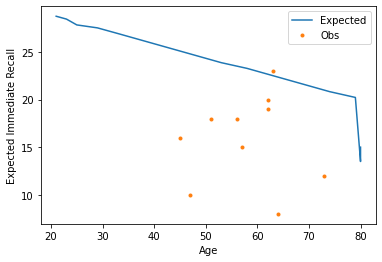

In [5]:
bvmt_norm = pd.read_csv('data/testing/bvmtr_extract.csv')
ax = bvmt_norm.plot(x = 'MaxAge', y = 'Total', label = 'Expected')
bvmt_all.plot(x = 'Age', y = 'BVMTimmed', ax=ax, label = 'Obs',
              marker = '.', linestyle = '')
ax.set_ylabel('Expected Immediate Recall')
bvmt_norm.head()

As expected, the average expected number of cards recalled goes down with age (blue line).
The plotted points mostly fall below this line, indicating that they are performing worse compared to age-matched controls.
Let's use a transformer to correct for these problems.

In [11]:
#export
#hide

FILTER_MAPPINGS = {'gt': '>',
                   'gte': '>=',
                   'lte': '<=',
                   'lt': '<',
                   'eq': '==',
                   'neq': '!='}



def _build_filters(lookup_table):
    """
    Build filters from lookup table
    Parameters
    ----------
    lookup_table : pd.DataFrame

    Returns
    -------

    """


    filts = dict((_id, []) for _id in lookup_table.index)
    expected = set()
    for col in lookup_table.columns:
        if '__' in col:
            field, nop = col.split('__')
            op = FILTER_MAPPINGS.get(nop, None)
            if op is not None:
                expected.add(field)
                for ind, val in lookup_table[col].to_dict().items():
                    if type(val) == str:
                        filts[ind].append(f'({field} {op} "{val}")')
                    else:
                        filts[ind].append(f'({field} {op} {val})')
    return pd.Series([' & '.join(filts[ind]) for ind in lookup_table.index],
                     index = lookup_table.index), sorted(expected)

def _build_lookup_norms(lookup_table):
    """

    Pulls out the values of the __mean and __std columns to create a
    pd.Series of scipy.norm instances.

    This can be better generalized in the future.

    Parameters
    ----------
    lookup_table : pd.DataFrame

    Returns
    -------
    ps.Series
    """

    mean_col = next(col for col in lookup_table.columns if col.endswith('__mean'))
    std_col = next(col for col in lookup_table.columns if col.endswith('__std'))

    field = mean_col.split('__')[0]

    return mean_col, std_col, field



    norm_list = []
    for _, row in lookup_table.iterrows():
        norm_list.append(norm(loc = row[mean_col],
                               scale = row[std_col]))
    return pd.Series(norm_list, index = lookup_table.index), fields




class LookupNormalTransform(object):

    def __init__(self, lookup_table=None, name = ''):
        """

        Parameters
        ----------
        lookup_table : pd.DataFrame
          Formatted lookup-table for the transformer
        """

        self.lookup_table = lookup_table
        self.name = name
        self._fit(lookup_table)


    def _fit(self, lookup_table):
        self._filters, self._filter_cols = _build_filters(lookup_table)
        self._mean_col, self._std_col, self._measure_col = _build_lookup_norms(lookup_table)

    @property
    def needed_cols(self):
        """

        Returns
        -------
        list[str]

        """
        return self._filter_cols + [self._measure_col]

    def get_feature_names(self):
        """

        Returns
        -------
        list[str]
        """
        return [self.name]

    def match_samples(self, data, keep = 'last'):
        """ Match samples to their respective rows.

        Parameters
        ----------
        data : pd.DataFrame
        keep : str
            Which item to keep. Currently only accepts 'last'

        Returns
        -------
        pd.Series

        """
        
        linker_func = lambda flt: data.query(flt).index
        all_matches = [(num, linker_func(f)) for num, f in  self._filters.to_dict().items()]
        
        data2flt = {}
        for num, matches in all_matches:
            for d_ind in matches:
                data2flt[d_ind] = num
        data2flt = pd.Series(data2flt)
        return data2flt.reindex(data.index)


    def normalize_samples(self, data, matched_rows = None):
        """ Normalize samples to z-scale based on the scheme

        Parameters
        ----------
        data : pd.DataFrame
        matched_rows : pd.Series
          Pre-calculated matching of the rows to each filter index.

        Returns
        -------
        pd.Series

        """

        if matched_rows is None: matched_rows = self.match_samples(data)

        valid_matches = matched_rows.dropna()
        obs_vals = data.loc[valid_matches.index, self._measure_col]
        means = self.lookup_table.loc[valid_matches.values, self._mean_col]
        stds = self.lookup_table.loc[valid_matches.values, self._std_col]
        Zs = pd.Series((obs_vals.values-means.values)/stds.values,
                       valid_matches.index,
                       name = self.name)

        return Zs.reindex(data.index)


    def transform(self, data):
        """

        Parameters
        ----------
        data : pd.DataFrame

        Returns
        -------
        pd.DataFrame

        """

        return pd.DataFrame(self.normalize_samples(data))


We will need to re-arrange the normalization table into a more suitable format.
This uses __ to indicate operations based on a currently limited language.
These need to map to the same columns as the input data.

In [12]:
mapping = {'MinAge':'Age__gte',
           'MaxAge':'Age__lte',
           'Total': 'BVMTimmed__mean',
           'Total-STD': 'BVMTimmed__std',
           }
immed_extracted_norm = bvmt_norm.rename(columns = mapping)[mapping.values()]
immed_extracted_norm.head()

,Age__gte,Age__lte,BVMTimmed__mean,BVMTimmed__std
0,18,21,28.74,4.32
1,20,23,28.44,4.38
2,24,25,27.83,4.48
3,26,29,27.52,4.54
4,30,33,26.92,4.64


In [13]:
transform_immed = LookupNormalTransform(immed_extracted_norm,
                                        name = 'BVMTimmed')

# You can extract the index of matched samples
hits = transform_immed.match_samples(bvmt_all)

# Or transform into normalized Z-scores directly
z_scores_immed = transform_immed.normalize_samples(bvmt_all)
z_scores_immed = transform_immed.transform(bvmt_all)

In [16]:
# We can create a second one and then merge them
mapping = {'MinAge':'Age__gte',
           'MaxAge':'Age__lte',
           'DR': 'BVMTdelay__mean',
           'DR-STD': 'BVMTdelay__std',
           }
dr_extracted_norm = bvmt_norm.rename(columns = mapping)[mapping.values()]

transform_dr = LookupNormalTransform(dr_extracted_norm,
                                     name = 'BVMTdelay')

Cool, but I don't want to have to build each one one at a time.
So, there are some utility functions.


In [19]:
#export

def build_merged_transformers(df, groupings, universal_cols = None,
                              prefix = '',
                              transform_class = LookupNormalTransform,
                              skip_final = False):
    """
    Build a set of merged transformers.

    Parameters
    ----------
    df : pd.DataFrame
    groupings : dict
    universal_cols : list
    prefix : str
    transform_class : cls
    skip_final : bool
      Useful if chaining multiple calls together before constructing the transformer.

    Returns
    -------
    ColumnTransformer

    """

    if universal_cols is None: universal_cols = []

    for key, cols in groupings.items():
        yield transform_class(name = key,
                              lookup_table=df[cols+universal_cols])


In [20]:
# Learn,Learn-STD,ret,ret-STD
# BVMT_hit BVMT_FP

bvmt_formatted = bvmt_norm.rename(columns={'MinAge':'Age__gte',
                                           'MaxAge':'Age__lte',
                                           'DR': 'BVMTdelay__mean',
                                           'DR-STD': 'BVMTdelay__std',
                                           'Total': 'BVMTimmed__mean',
                                           'Total-STD': 'BVMTimmed__std',
                                           'Disc': 'BVMTrecog__mean',
                                           'Disc-STD': 'BVMTrecog__std'})



bvmt_groupings = {'BVMTimmed': ['BVMTimmed__mean', 'BVMTimmed__std'],
                  'BVMTdelay': ['BVMTdelay__mean', 'BVMTdelay__std'],
                  'BVMTrecog': ['BVMTrecog__mean', 'BVMTrecog__std']
                  }

bvmt_transforms = build_merged_transformers(bvmt_formatted, bvmt_groupings,
                                           universal_cols = ['Age__gte', 'Age__lte'],
                                           prefix = 'lookup_', transform_class = LookupNormalTransform)
for tf in bvmt_transforms:
    print(tf.name, tf.transform(bvmt_all))


BVMTimmed     BVMTimmed
0         NaN
1         NaN
2         NaN
3   -0.679035
4   -0.493506
5   -0.998106
6   -1.133205
7    0.172727
8   -2.856016
9   -1.566288
10  -2.554545
11  -1.832661
12  -1.546410
BVMTdelay     BVMTdelay
0         NaN
1         NaN
2         NaN
3   -1.215962
4   -1.215962
5   -0.882927
6         NaN
7   -0.622727
8   -2.763158
9   -1.370732
10  -2.895455
11  -1.349727
12  -2.088983
BVMTrecog     BVMTrecog
0         NaN
1         NaN
2         NaN
3   -1.954545
4    0.318182
5   -2.948276
6         NaN
7    0.166667
8   -8.142857
9   -2.948276
10  -4.000000
11   0.291667
12  -0.703297


In [21]:
#export

def build_from_yaml(path, _nested = False):

    if type(path) is str:
        config = yaml.full_load(open(path))
        direc = os.path.dirname(path)
        lk_data_path = os.path.join(direc, config['lookup_table'])
        lk_data = pd.read_csv(lk_data_path)
        return build_merged_transformers(lk_data, config['groupings'],
                                         universal_cols = config['universal_cols'],
                                         prefix = config['short_name'],
                                         transform_class = LookupNormalTransform,
                                         skip_final = _nested)
    else:
        all_transformers = chain.from_iterable(build_from_yaml(p) for p in path)
        return all_transformers

In [22]:
ex_path = 'data/norms/from_kate/BVMTR/description.yaml'
for tf in build_from_yaml(ex_path):
    print(tf.name, tf.transform(bvmt_all).mean())


BVMTimmed BVMTimmed   -1.348705
dtype: float64
BVMTdelay BVMTdelay   -1.600626
dtype: float64
BVMTrecog BVMTrecog   -2.213415
dtype: float64


That worked great.
However, some norms are regression based.
Utilizing these norms requires a 2 step process.
First, raw values need to be scaled into the units used by the researcher.
Then, the scaled values are used in a regression equation along with demographic variables.

We'll use the BVMTdelay for Caucasians from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3154384/

In [24]:
scale_data = pd.read_csv('data/testing/heaton_bvtm_scales.csv').sort_values('max')
scale_data

,scaled,min,max
9,2,0,2
8,3,3,3
7,4,4,4
6,5,5,6
5,6,7,7
4,7,8,8
3,8,9,9
2,9,10,10
1,11,11,11
0,14,12,12


In [25]:
scale_ser = pd.Series(scale_data['scaled'].values,
                      index = pd.IntervalIndex.from_arrays(scale_data['min'].values,
                                                           scale_data['max'].values,
                                                           closed='both'))


pd.DataFrame({'raw':bvmt_all['BVMTdelay'],
              'scaled': bvmt_all['BVMTdelay'].map(scale_ser.get)})



,raw,scaled
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,6.0,5.0
4,6.0,5.0
5,7.0,6.0
6,NaN,NaN
7,7.0,6.0
8,4.0,4.0
9,6.0,5.0


Now we have to deal with the regression equation.

((scaled-(0.2267*(Education-13.86) + (-0.1262)*(Age-40.63) + 0.8593*heaton_gender + 7.691))/2.5197)*10 + 50
Heaton_gender is 1 for female and 0 for male.

In [26]:

# Slightly Edited for z-scaling
eqn = "(scaled-(0.2267*(Education-13.86) + (-0.1262)*(Age-40.63) + 0.8593*heaton_gender + 7.691))/2.5197"

cal_data = pd.DataFrame({'scaled': bvmt_all['BVMTdelay'].map(scale_ser.get),
                         'Education': bvmt_all['Education'],
                         'Age': bvmt_all['Age'],
                         'heaton_gender': bvmt_all['Sex'].replace({1: 0,
                                                                   2: 1})})

normed_data = ne.evaluate(eqn, local_dict=cal_data)
normed_data

array([        nan,         nan,         nan,  0.16968528, -0.19019883,
        0.0861039 ,         nan,  0.61664325, -0.79852522,  0.18917173,
       -1.28064611, -0.44598325,  0.10682065])

Sweet, Z-scaled data!
But not everyone is Caucasian, we need a way to adjust the scaling based on other factors.
We'll use another subclass of the sklearn API to make our lives easier again.

First, we'll make a node that encapsulates the logic renaming columns and syncing coding that can be shared across implementations.
Then we'll need another node that matches filters and calculating the values.

In [27]:
#export

class EncodingTransform(object):

    def __init__(self, replacements = None, renames = None):

        if replacements is None: replacements = {}
        if renames is None: renames = {}

        self.replacements = replacements
        self.renames = renames
        self.rev_renames = dict((val, key) for key, val in renames.items())


    def reverse_col_lookup(self, col):
        return self.rev_renames.get(col, col)

    def forward_col_lookup(self, col):
        return self.renames.get(col, col)

    def extract_data(self, data, needed_cols, added_cols = None, replacements = None):
        """

        Parameters
        ----------
        data : pd.DataFrame
        needed_cols: list[str]
        added_cols : dict
        replacements : dict

        Returns
        -------

        pd.DataFrame

        """

        if replacements is None: replacements  = {}
        needed_cols = set(self.reverse_col_lookup(col) for col in needed_cols)
        wdata = data.reindex(sorted(needed_cols), axis=1)
        if added_cols is not None:
            wdata = pd.concat([wdata, pd.DataFrame(added_cols)], axis=1)


        replacements = {**replacements, **self.replacements}
        wdata.replace(replacements, inplace=True)

        if self.renames is not None:
            wdata.rename(columns = self.renames, inplace=True)

        return wdata


In [28]:
encoder_transform = EncodingTransform(replacements = {'Sex': {1: 0,
                                                              2: 1},
                                                      'Race': {2: 'AA',
                                                               1: 'White'}},
                                      renames = {'Sex': 'heaton_gender',
                                                 'Race': 'RaceCat'})

In [29]:
#export

def _convert_scales(scale_obj):

    data = pd.DataFrame(scale_obj).sort_values('Max')

    #print(data)

    index = pd.IntervalIndex.from_arrays(data['Min'].values, data['Max'].values,
                                         closed='both')
    #print(pd.Series(data['scaled'].values, index = index))

    return pd.Series(data['scaled'].values, index = index)

class ScaledRegressionNode(object):

    def __init__(self, field, scale_col, scales, flt, eqn, needed_cols,
                 result = 'zscale', transform = None):
        """

        Parameters
        ----------
        field : str
        scale_col : str
        scales : pd.Series
        flt : str
        eqn : str
        needed_cols : list[str]
        result : str
        replacements : dict
        """

        self.field = field
        self.scale_col = scale_col

        assert type(scales.index) == pd.IntervalIndex
        self.scales = scales

        self.flt = flt
        self.eqn = eqn
        self.needed_cols = needed_cols
        self.transformer = transform
        self.result = result

    @staticmethod
    def from_yaml(path, typ = 'tscore', transform = None):

        if transform is None:
            rev_lookup = lambda x: x
        else:
            rev_lookup = lambda x: transform.reverse_col_lookup(x)

        with open(path) as handle:
            obj = yaml.full_load(handle)
        try:
            return ScaledRegressionNode(field = obj['short_name'],
                                        scale_col = obj['scale_column'],
                                        scales = _convert_scales(obj['scores']),
                                        flt = obj['Population_filter'],
                                        eqn = obj[typ],
                                        needed_cols = [rev_lookup(x) for x in (obj['filter_cols'] + obj[typ+'_cols'])],
                                        result = typ,
                                        transform = transform)
        except ValueError:
            print(f'Failed on {path}')
            raise



    def extract_data(self, data, **kwargs):

        return self.transformer.extract_data(data, self.needed_cols, **kwargs)

    def extract_filter_data(self, data, **kwargs):

        return self.extract_data(data, **kwargs).query(self.flt)

    def scale_data(self, raw_values):
        """

        Parameters
        ----------
        raw_values : pd.Series

        Returns
        -------
        pd.Series

        """

        return raw_values.map(self.scales.get)

    def transform(self, data):
        return self.norm_data(data)

    def norm_data(self, data):

        scaled = self.scale_data(data[self.transformer.reverse_col_lookup(self.scale_col)])
        wdata = self.extract_filter_data(data, added_cols={'scaled': scaled})
        try:
            res = ne.evaluate(self.eqn, local_dict=wdata)
        except:
            print(wdata)
            raise

        res = pd.Series(res, index = wdata.index,
                        name = self.field)
        if self.result == 'tscore':
           res = (res-50)/10
        return res

In [30]:

eqn = "(scaled-(0.2267*(Education-13.86) + (-0.1262)*(Age-40.63) + 0.8593*heaton_gender + 7.691))/2.5197"
flt = '(RaceCat == "AA") & ((Age >= 18) & (Age <= 66))'

smaller_data = bvmt_all


cal_data = pd.DataFrame({'scaled': bvmt_all['BVMTdelay'].map(scale_ser.get),
                         'Education': bvmt_all['Education'],
                         'Age': bvmt_all['Age'],
                         'heaton_gender': bvmt_all['Sex'].replace()})


node = ScaledRegressionNode('test', 'BVMTdelay', scale_ser, flt, eqn,
                            ['Age', 'Sex', 'Education', 'BVMTdelay', 'Race'],
                            result = 'zscale',
                            transform = encoder_transform)


In [31]:
#export

class ScaledRegressionTransform(object):

    def __init__(self, name = '', norm_nodes=None):
        """

        Parameters
        ----------
        norm_nodes : list[ScaledRegressionNode]
          Formatted lookup-table for the transformer
        """


        self.norm_nodes = norm_nodes
        self.name = name


    @staticmethod
    def from_yaml(paths, name = '', transform=None):
        nodes = [ScaledRegressionNode.from_yaml(path, transform=transform) for path in paths]
        return ScaledRegressionTransform(name = name,
                                         norm_nodes = nodes)

    def fit(self, *args, **kwargs):
        return self

    @property
    def needed_cols(self):
        cols = set()
        for node in self.norm_nodes:
            cols |= set(node.needed_cols)
        return sorted(cols)

    @property
    def out_fields(self):
        return sorted(set(node.field for node in self.norm_nodes))

    def get_feature_names(self):
        if len(self.name):
            return [self.name + '__' + node.field for node in self.norm_nodes]
        else:
            return self.out_fields

    def normalize_samples(self, data, aggfunc = 'last'):

        index_key = data.index.name
        if index_key is None:
            data.index.name = 'index'
            index_key = 'index'
        #print('index', index_key)
        out_data = []
        for node in self.norm_nodes:
            out_data.append(node.transform(data).reset_index())

        out_data = pd.concat(out_data, axis=0, ignore_index=True)
        if len(out_data.index) == 0: # nobody matched the filter
            return pd.Series([np.nan]*len(data.index),
                             index = data.index)

        out_piv = out_data.groupby(index_key)[self.out_fields].agg(aggfunc)
        return out_piv.reindex(data.index, axis=0)

    def transform(self, data):
        return self.normalize_samples(data, aggfunc = 'first')


In [32]:
heaton_transform = EncodingTransform(replacements = {'Sex': {1: 0,
                                                              2: 1},
                                                      'Race': {2: 'AA',
                                                               1: 'White'}},
                                      renames = {'Sex': 'heaton_gender',
                                                 'Race': 'RaceCat',
                                                 'BVMTimmed': 'BVMTtotalrecal',
                                                 'HVLT.total': 'HVLTtotalrecal'
                                                  })




heaton_normer = ScaledRegressionTransform.from_yaml(['data/norms/heaton/heaton_AA_BVMTdelay.yaml',
                                                     'data/norms/heaton/heaton_AA_BVMTtotalrecall.yaml',
                                                     'data/norms/heaton/heaton_White_BVMTdelay.yaml',
                                                     'data/norms/heaton/heaton_White_BVMTtotalrecall.yaml',
                                                     ], transform=heaton_transform)


In [33]:
heaton_res = heaton_normer.normalize_samples(bvmt_all)
heaton_res.head()

,BVMTdelay,BVMTtotalrecal
index,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.169685,0.725010
4,-0.190199,0.283938
